In [128]:
import importlib
import main

importlib.reload(main)

<module 'main' from '/Users/alessandramancas/Desktop/uni/IFT3335/TP2_IFT3335/TP2_code/main.py'>

In [100]:
import os.path
import sys

import pandas as pd
import numpy as np
from collections.abc import Sequence
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn import svm
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

import matplotlib
import transformers
import re  # regex library

import mlens
from mlens.ensemble import SuperLearner

In [101]:
# Prétraitement & splitting des datasets 
df = pd.read_csv('spam_train.csv')

# Preprocess the data
df['text'] = main.pretraitement(df['text'])
df['label'] = pd.to_numeric(df['label'], downcast='integer', errors='coerce')
# print(df.head())

fm = main.bag_of_words(df['text'], 5000)
fm_train, fm_test, y1_train, y1_test = train_test_split(fm, df['label'], random_state=42)
# print(fm.head)

tfidf = main.tf_idf(df['text'], 5000)
tfidf_train, tfidf_test, y2_train, y2_test = train_test_split(tfidf, df['label'], random_state=42)
# print(tfidf_train.head)


In [102]:
models = {
    "Logistic Regression": linear_model.LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "MultiLayer Perceptron": MLPClassifier()
}

scores_global = {
    "Logistic Regression": [],
    "Random Forest": [],
    "MultiLayer Perceptron": []
}




### Partie 1 ###

In [103]:

for model in models:
    print("training model " + model)

    # BoW & TF-IDF (partie 1)
    classifier = models[model]
    bow_cross_val, bow_accuracy, bow_f1 = main.train_model(classifier, fm_train, y1_train, fm_test, y1_test)
    tfidf_cross_val, tfidf_accuracy, tfidf_f1 = main.train_model(classifier, tfidf_train, y2_train, tfidf_test, y2_test)
    
    scores_global[model].append([bow_cross_val, bow_accuracy, bow_f1])
    scores_global[model].append([tfidf_cross_val, tfidf_accuracy, tfidf_f1])

    print('bow cross_val', bow_cross_val)
    print('bow accuracy', bow_accuracy)
    print('bow f1', bow_f1, '\n')

    print('tfidf cross_val', tfidf_cross_val)
    print('tfidf accuracy', tfidf_accuracy)
    print('tfidf f1', tfidf_f1, '\n')

training model Logistic Regression
bow cross_val 0.9713004484304933
bow accuracy 0.9874439461883409
bow f1 0.9477611940298507 

tfidf cross_val 0.8968609865470853
tfidf accuracy 0.957847533632287
tfidf f1 0.8 

training model Random Forest
bow cross_val 0.9452914798206278
bow accuracy 0.9766816143497757
bow f1 0.8984375 

tfidf cross_val 0.9497757847533632
tfidf accuracy 0.9775784753363229
tfidf f1 0.9027237354085603 

training model MultiLayer Perceptron
bow cross_val 0.9721973094170403
bow accuracy 0.9874439461883409
bow f1 0.9477611940298507 

tfidf cross_val 0.9739910313901345
tfidf accuracy 0.9856502242152466
tfidf f1 0.9407407407407408 



**Quelle méthode (BoW ou TF-IDF) donne les meilleurs résultats ? Pourquoi pensez- vous que c’est le cas ?** 

Un cross-validation score plus élevé indique que le modèle performe mieux sur des données non vues. Un accuracy plus élevé indique que le modèle fait des prédictions assez proches de leur valeur réelle. Un F1 score plus élevé indique que le modèle fait moins de faux positifs et faux négatifs.

En regardant les scores de la cellule ci-dessus, on constate que:

Pour LR: on a une meilleure performance avec BoW sur toutes les métriques 
Pour RF: on a une légèrement meilleure performance avec TF-IDF sur toutes les métriques
Pour MLP: on a une légèrement meilleure performance avec BoW sur l'accuracy et le F1 score, mais pas pour le cross-validation score

On pense que le Random Forest aurait une meilleure performance sur TF-IDF, car cette méthode capture les relations entre les tokens et ainsi facilite la prise de décision pour les arbres du modèle. BoW fonctionne mieux pour des modèles linéaires simples, comme la régression logistique, car il nous donne simplement la fréquence de chaque mot dans le corpus, ce qui est suffisant pour des modèles linéaires plus simples. La performance du MLP est mixte sur les deux méthodes (à un centième près pour le cross-validation score), car avec BoW un biais peut être induit avec les stopwords, tandis que TF-IDF permet au modèle de mieux distinguer les mots importants des documents. [review?!??!?]


In [104]:
# Voyons si la performance change si on diminue max_features 
import matplotlib.pyplot as plt

max_features_values = [1000,2000,3000,4000,5000]


for model in models:

    cv_score = {
        'BoW': [], 
        'TF-IDF': []
    }
    accuracy = {
        'BoW': [], 
        'TF-IDF': []
    }
    f1 = {
        'BoW': [], 
        'TF-IDF': []
    }

    print("training model " + model)

    for v in max_features_values:
        fm = main.bag_of_words(df['text'], v)
        fm_train, fm_test, y1_train, y1_test = train_test_split(fm, df['label'], random_state=42)

        tfidf = main.tf_idf(df['text'], v)
        tfidf_train, tfidf_test, y2_train, y2_test = train_test_split(tfidf, df['label'], random_state=42)

        classifier = models[model]
        bow_cross_val, bow_accuracy, bow_f1 = main.train_model(classifier, fm_train, y1_train, fm_test, y1_test)

        cv_score['BoW'].append(bow_cross_val)
        accuracy['BoW'].append(bow_accuracy)
        f1['BoW'].append(bow_f1)

        tfidf_cross_val, tfidf_accuracy, tfidf_f1 = main.train_model(classifier, tfidf_train, y2_train, tfidf_test, y2_test)

        cv_score['TF-IDF'].append(tfidf_cross_val)
        accuracy['TF-IDF'].append(tfidf_accuracy)
        f1['TF-IDF'].append(tfidf_f1)

    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # Construire les graphiques des métriques pour chaque modèle 
    for label, y in cv_score.items():
        ax[0].plot(max_features_values, y, label=label)

    ax[0].legend()
    ax[0].set_xlabel('# de max_features')
    ax[0].set_ylabel('cross-val score')
    ax[0].set_title('CV scores')

    for label, y in accuracy.items():
        ax[1].plot(max_features_values, y, label=label)

    ax[1].legend()
    ax[1].set_xlabel('# de max_features')
    ax[1].set_ylabel('accuracy score')
    ax[1].set_title('Accuracy scores')

    for label, y in f1.items():
        ax[2].plot(max_features_values, y, label=label)

    ax[2].legend()
    ax[2].set_xlabel('# de max_features')
    ax[2].set_ylabel('f1score')
    ax[2].set_title('F1 scores')

    fig.suptitle(model)

**Que se passe-t-il pour les metriques si vous diminuez max_features ? (Montrez un graphique)**

[ Roulez la cellule ci-dessus si rien ne s'affiche, dure ~2min] 

On observe que la performance diminue considérablement pour TF-IDF lorsqu'on augmente max_features, alrs que les scores pour BoW restent assez consistants mais tendent vers le bas. Cette tendance est évidente pour MLP et LR, mais elle varie beaucoup plus pour random forest (comme nous avons vu dans la question 1, où il arrive que l'accuracy et le F1 pour BoW soit supérieur parfois à TF-IDF). Toutefois, comme pour la question 1, BoW semble toujours mieux performer pour MLP et LR. On remarque une chute de la performance du MLP quand max_features dépasse 4000, peut-être à cause d'un surapprentissage. 


### Partie 2 ###



In [105]:
vector = []

batch_size = 32
for i in tqdm(range(0, len(df), batch_size), desc="processing batches"):
    batch = df["text"][i:i+batch_size]
    vector.extend(main.to_embedding(batch))

embed_train, embed_test, y3_train, y3_test = train_test_split(vector, df["label"], random_state=42)

for model in models:
    print("training model " + model)
    classifier = models[model]

    embed_cross_val, embed_accuracy, embed_f1 = main.train_model(classifier, embed_train, y3_train, embed_test, y3_test)
    print('embed_cross_val', embed_cross_val, "\n")

    scores_global[model].append([embed_cross_val, embed_accuracy, embed_f1])
    print(scores_global)

processing batches: 100%|██████████| 140/140 [01:19<00:00,  1.75it/s]


training model Logistic Regression
embed_cross_val 0.9605381165919281 

{'Logistic Regression': [[np.float64(0.9713004484304933), 0.9874439461883409, np.float64(0.9477611940298507)], [np.float64(0.8968609865470853), 0.957847533632287, np.float64(0.8)], [np.float64(0.9605381165919281), 0.97847533632287, np.float64(0.9097744360902256)]], 'Random Forest': [[np.float64(0.9452914798206278), 0.9766816143497757, np.float64(0.8984375)], [np.float64(0.9497757847533632), 0.9775784753363229, np.float64(0.9027237354085603)]], 'MultiLayer Perceptron': [[np.float64(0.9721973094170403), 0.9874439461883409, np.float64(0.9477611940298507)], [np.float64(0.9739910313901345), 0.9856502242152466, np.float64(0.9407407407407408)]]}
training model Random Forest
embed_cross_val 0.9255605381165919 

{'Logistic Regression': [[np.float64(0.9713004484304933), 0.9874439461883409, np.float64(0.9477611940298507)], [np.float64(0.8968609865470853), 0.957847533632287, np.float64(0.8)], [np.float64(0.9605381165919281), 0

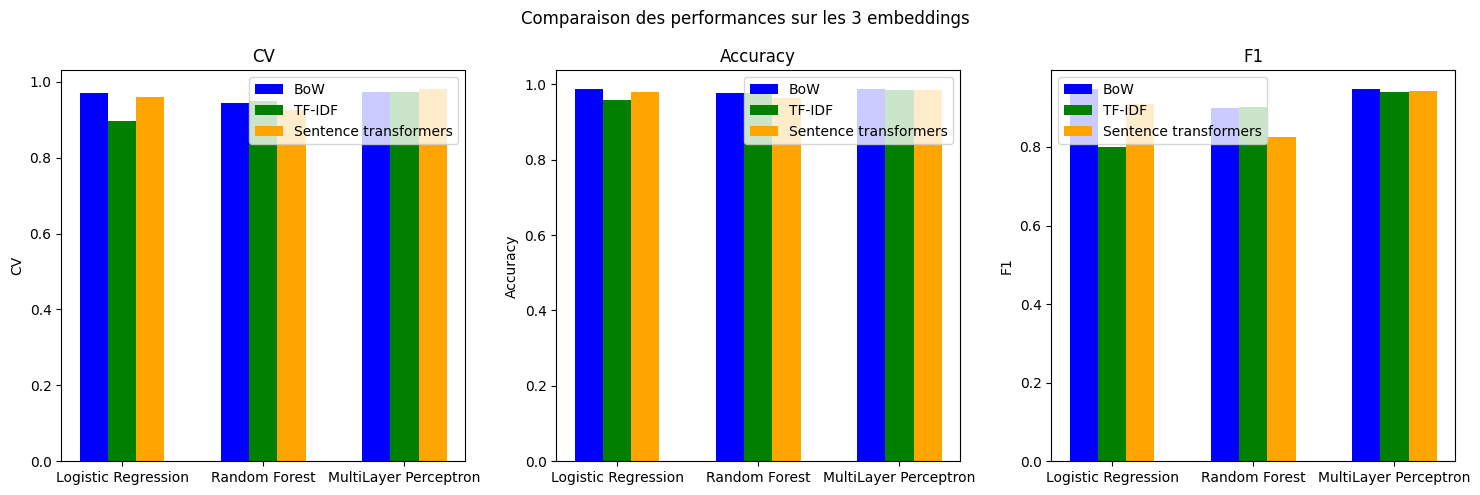

In [106]:
metrics = ['CV', 'Accuracy', 'F1']
variants = ['BoW', 'TF-IDF', 'Sentence transformers']
num_variants = len(variants)
model_names = list(scores_global.keys())
x = np.arange(len(model_names))
bar_width = 0.2  # smaller width to fit 3 bars

# Extract values for each metric and each variant
metric_values = {metric: [[] for _ in range(num_variants)] for metric in metrics}

for values in scores_global.values():
    for i, metric in enumerate(metrics):
        for j in range(num_variants):
            metric_values[metric][j].append(values[j][i])

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['blue', 'green', 'orange']

for i, metric in enumerate(metrics):
    ax = axes[i]
    for j in range(num_variants):
        offset = (j - 1) * bar_width  # positions: -bar_width, 0, +bar_width
        ax.bar(x + offset, metric_values[metric][j], width=bar_width, label=f'{variants[j]}', color=colors[j])

    ax.set_title(f'{metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylabel(metric)
    ax.legend()

fig.suptitle('Comparaison des performances sur les 3 embeddings')
plt.tight_layout()
plt.show()

[SVP roulez les 2 cellules ci-dessus si aucun graphique est affiché!]

**Comment les embeddings se comparent-ils à BoW et TF-IDF en termes de performance?**

Dans la plupart des cas, la performance des embeddings sur les différentes modèles est en fait inférieure à BoW ou TF-IDF. C'est seulement pour le MLP que son F1 et son accuracy sont un peu meilleurs que les 2 autres cas, puis qu'il a notamment un rappel et une précision parfaits avec le nouvel embedding. 

**Quels sont les avantages et inconvénients d’utiliser des embeddings pré-entraînés ?** 

Avantages: 
- Moins coûteux: pour entraîner un embedding *from scratch*, il faut avoir une énorme quantité de données (beaucoup de tokens, beaucoup de paramètres) qui sont très éparses, ce qui peut être coûteux à acquérir puis à traverser pour avoir des résultats significatifs. Avoir un embedding pré-entraîné enlève toute cette première étape.
- Meilleure performance: Les poids associés aux mots sont déjà favorables, cela facilitera donc l'apprentissage d'un classificateur et ce dernier aura probablement de meilleurs résultats On économise également du temps, car il ne faut pas tester et ajuster les paramètres de nos embeddings. 

Inconvénients
- OOV : Comme les embeddings pré-entrainés apprennent sur un vocabulaire donné, mais notre corpus peut différer de l'ensemble d'entraînement de l'embedding.
- Biais: L'embedding peut également être entraîné sur des données biaisées, sur lesquelles on n'a pas de contrôle 
- Coût: Les embeddings plus larges pourraient être coûteux à exécuter dû à ce large nombre de paramètres. 


https://www.geeksforgeeks.org/pre-trained-word-embedding-in-nlp/ 
https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/ 
https://datascience.stackexchange.com/questions/92856/the-reason-behind-using-a-pre-trained-model


### Partie 3 ###


In [110]:
# put everything from scores global in one big array 
for k in scores_global:
    temp = []
    for t in scores_global[k]:
        for e in t:
            temp.append(e)
    scores_global[k] = temp

In [129]:
scorers = {
        "acc": accuracy_score,
        "F1": f1_score,
}

weights = []

for scorer in scorers:
    accuracy, f1, poids = main.super_learner(tfidf_train, y2_train, tfidf_test, y2_test, scorers[scorer])
    weights.append(poids)
    print(accuracy, f1)



Fitting 2 layers
Fit complete                        | 00:00:22

Predicting 2 layers
Predict complete                    | 00:00:04


AttributeError: 'Sequential' object has no attribute '_meta_estimator'

In [119]:
scores_global["Super Learner"]=[None, None, None, None, accuracy, f1, None, None, None]

df_global = pd.DataFrame.from_dict(scores_global, orient='index',
                                   columns=["bow cross-val", "bow accuracy", "bow f1",
                                            "tfidf cross-val", "tfidf accuracy", "tfidf f1",
                                            "embed cross-val", "embed accuracy", "embed f1"])

In [120]:
df_global

,bow cross-val,bow accuracy,bow f1,tfidf cross-val,tfidf accuracy,tfidf f1,embed cross-val,embed accuracy,embed f1
Logistic Regression,0.971300,0.987444,0.947761,0.896861,0.957848,0.800000,0.960538,0.978475,0.909774
Random Forest,0.945291,0.976682,0.898438,0.949776,0.977578,0.902724,0.925561,0.962332,0.825000
MultiLayer Perceptron,0.972197,0.987444,0.947761,0.973991,0.985650,0.940741,0.981166,0.985650,0.942857
Super Learner,NaN,NaN,NaN,NaN,0.979372,0.911197,NaN,NaN,NaN


                       bow cross-val  bow accuracy    bow f1  tfidf cross-val  \
Logistic Regression         0.971300      0.987444  0.947761         0.896861   
Random Forest               0.945291      0.976682  0.898438         0.949776   
MultiLayer Perceptron       0.972197      0.987444  0.947761         0.973991   
Super Learner                    NaN           NaN       NaN              NaN   

                       tfidf accuracy  tfidf f1  embed cross-val  \
Logistic Regression          0.957848  0.800000         0.960538   
Random Forest                0.977578  0.902724         0.925561   
MultiLayer Perceptron        0.985650  0.940741         0.981166   
Super Learner                0.979372  0.911197              NaN   

                       embed accuracy  embed f1  
Logistic Regression          0.978475  0.909774  
Random Forest                0.962332  0.825000  
MultiLayer Perceptron        0.985650  0.942857  
Super Learner                     NaN       NaN  


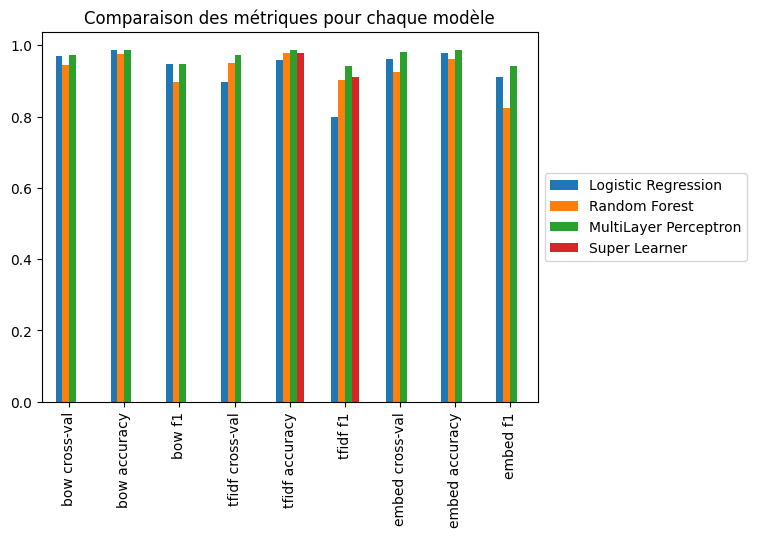

In [133]:
print(df_global)
df_global_transposed = df_global.T
# ax1 = df_global.plot.bar()
ax2 = df_global_transposed.plot.bar()

# ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#fig1 = ax1.get_figure()
#fig1.savefig("./scores1.png")
ax2.set_title("Comparaison des métriques pour chaque modèle")
fig2 = ax2.get_figure()
fig2.savefig("./scores2.png")



**Commenter les graphiques obtenus**

Le Super Learner a des performances assez similaires aux autres modèles, semblables au MLP ce qui fait du sens. [EXPLIQUER PK??]

**Quels sont les poids que votre méta-modèle a attribués à chaque modèle de base ?**

Malheureusement la version actuelle de mlens proposée dans l'énoncé ne nous permet pas d'accéder aux attributs nécessaires pour obtenir cette information. 